In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
from datetime import datetime
from torch.utils.data import DataLoader

In [5]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'
  

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='cifar10', train=True, transform=transform, download = True)
valid_dataset = datasets.CIFAR10(root='cifar10', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

Extracting cifar10/cifar-10-python.tar.gz to cifar10


torch.Size([3, 32, 32]) 9


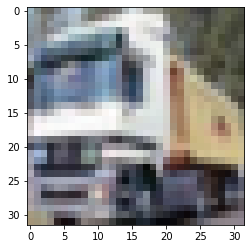

In [7]:
img, label = train_dataset[1]
print(img.shape, label)
img = img.numpy()

plt.imshow(img.transpose((1, 2, 0)))

In [8]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    self.relu = nn.Sequential(
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels)
    )
    self.res = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
    )

  def forward(self, x):
    layer = self.conv1(x)
    layer = self.conv2(layer)
    x = self.res(x)
    return self.relu(x + layer)


In [35]:
ResBlock()

TypeError: ignored

In [9]:
class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.a = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(3, stride=2, padding=1),
        ResBlock(64, 64, 2),
        ResBlock(64, 64, 2),
        ResBlock(64, 128, 1),
        ResBlock(128, 128, 1),
        ResBlock(128, 256, 1),
        ResBlock(256, 256, 1),
        ResBlock(256, 512, 1),
        ResBlock(512, 512, 1),
        nn.AvgPool2d(2)
    )
    self.b = nn.Sequential(
        nn.Linear(512, 10)
    )

  def forward(self, X):
    x = self.a(X)
    logits = torch.flatten(x, 1)
    logits = self.b(logits)
    probs = F.softmax(logits, 1)
    return logits, probs

![ResNet Architecture](ResNet_VGG_architecture.png "ResNet")

In [13]:
def init_weights(m):
  if type(m) == nn.Conv2d or type(m) == nn.Linear:
    torch.nn.init.xavier_uniform(m.weight)
    m.bias.data.fill_(0.01)



In [11]:
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for X, y in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0

  for X, y in valid_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device):
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  for epoch in range(0, epochs):
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    train_acc = get_accuracy(model, train_loader, device)
    valid_acc = get_accuracy(model, valid_loader, device)

    print(f'{datetime.now().time().replace(microsecond=0)} ---- '
          f'Epoch: {epoch}\t'
          f'Train Loss: {train_loss:.4f}\t'
          f'Valid Loss: {valid_loss:.4f}\t'
          f'Train Accuracy: {100 * train_acc:.2f}\t'
          f'Valid Accuracy: {100 * valid_acc:.2f}')
      
  plot_losses(train_losses, valid_losses)
  return model, optimizer, (train_losses, valid_losses)


def get_accuracy(model, data_loader, device):
  correct_pred = 0
  n = 0
  with torch.no_grad():
    model.eval()
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)
      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y.size(0)
      correct_pred += (y == predicted_labels).sum()

    return correct_pred.float()/n

def plot_losses(train_losses, valid_losses):
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig,ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color='blue', label='Training loss')
  ax.plot(valid_losses, color='red', label='Validation loss')
  ax.set(title='Loss over epochs',  xlabel='Epoch', ylabel='loss')
  ax.legend()
  fig.show()

  plt.style.use('default')

In [ ]:
model = ResNet()
model = model.to(DEVICE)
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# print(model)

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, 20, DEVICE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


11:51:13 ---- Epoch: 0	Train Loss: 1.4939	Valid Loss: 1.7067	Train Accuracy: 46.45	Valid Accuracy: 45.73
11:52:09 ---- Epoch: 1	Train Loss: 1.1196	Valid Loss: 1.2533	Train Accuracy: 57.99	Valid Accuracy: 56.20
11:53:05 ---- Epoch: 2	Train Loss: 0.9554	Valid Loss: 1.2359	Train Accuracy: 61.18	Valid Accuracy: 57.92
11:54:01 ---- Epoch: 3	Train Loss: 0.8500	Valid Loss: 1.0353	Train Accuracy: 70.21	Valid Accuracy: 65.26
11:54:58 ---- Epoch: 4	Train Loss: 0.7596	Valid Loss: 1.1593	Train Accuracy: 68.28	Valid Accuracy: 62.48
11:55:54 ---- Epoch: 5	Train Loss: 0.6901	Valid Loss: 1.0763	Train Accuracy: 71.27	Valid Accuracy: 64.75
11:56:49 ---- Epoch: 6	Train Loss: 0.6265	Valid Loss: 0.9604	Train Accuracy: 77.03	Valid Accuracy: 67.89
11:57:46 ---- Epoch: 7	Train Loss: 0.5708	Valid Loss: 0.9173	Train Accuracy: 80.99	Valid Accuracy: 70.03
11:58:42 ---- Epoch: 8	Train Loss: 0.5147	Valid Loss: 0.8909	Train Accuracy: 84.74	Valid Accuracy: 71.58
11:59:38 ---- Epoch: 9	Train Loss: 0.4745	Valid Loss: 0